# [NML'22] assignment 1: Graph theory basics

[Ping Hu, EPFL, ASL](https://people.epfl.ch/ping.hu?lang=en) and [Arun Venkitaraman, EPFL, LTS4.](https://people.epfl.ch/arun.venkitaraman/)

## Students

* Team: `3`
* Students: `Joe Najm, Sébastien Jeanfavre`

## Rules

Grading:
* All team members will receive the same grade based on the team solution.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first except for the Question 4 of Section 1 (at the indicated portion only).
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this assignment is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

Let us first download the cora dataset:

In [1]:
#!wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
!tar -xvf cora.tgz

x cora/
x cora/README
x cora/cora.cites
x cora/cora.content


## Section 1: Network Properties

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [20]:
df = pd.read_csv('./cora/cora.content', sep='\t', header=None, index_col=0)
df = df.rename(columns={1434: 'label'})
df.head()

,1,2,3,4,5,6,7,8,9,10,...,1425,1426,1427,1428,1429,1430,1431,1432,1433,label
0,,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [4]:
df.loc[:,'label'].value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [5]:
my_field = 'Reinforcement_Learning'
features = df[df['label']==my_field].drop(columns='label').to_numpy()
features.shape

(217, 1433)

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. (Needs to modify!!!)

In [6]:
distance = np.zeros((features.shape[0],features.shape[0]))

for i in range(features.shape[0]):
    for j in range(features.shape[0]):
        distance[i,j] = np.linalg.norm(features[i,:] - features[j,:])

distance.shape

(217, 217)

Check the mean pairwise distance $\mathbb{E}[D]$.

In [7]:
mean_distance = distance.mean()
mean_distance

5.781074820974051

Plot an histogram of the euclidean distances.

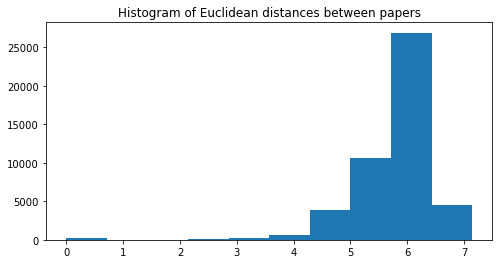

In [8]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten());

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

Remember that we are going to use adjacency without self-loops

In [9]:
threshold = mean_distance
A_feature = distance.copy()
A_feature[distance>=threshold] = 0
A_feature[distance<threshold] = 1
A_feature -= np.eye(A_feature.shape[0])

In [10]:
A_feature

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [13]:
cora_cites = np.genfromtxt('cora/cora.cites', delimiter='\t').astype(int)
# get graph edges and flatten them for processing

cites = pd.DataFrame(cora_cites).astype(int)
cites.columns = ['cited', 'citing']

print(cites)

       cited   citing
0         35     1033
1         35   103482
2         35   103515
3         35  1050679
4         35  1103960
...      ...      ...
5424  853116    19621
5425  853116   853155
5426  853118  1140289
5427  853155   853118
5428  954315  1155073

[5429 rows x 2 columns]


In [50]:
nb_papers = df.shape[0]

adj = pd.DataFrame(np.zeros((nb_papers,nb_papers))).astype(int)
adj.index = df.index
adj.columns = df.index

for i in range(cora_cites.shape[0]):
    adj.loc[cora_cites[i,1], cora_cites[i,0]] = 1

# adj is the adjacency matrix. Citing paper on rows and cited papers on columns
adj.shape

(2708, 2708)

In [51]:
# caution, we will first use the directed citation graph
A_citation = adj.to_numpy()
A_citation.shape

(2708, 2708)

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

In [52]:
adj_RL = adj.loc[adj.index.isin(df[df['label']==my_field].index)]
adj_RL = adj_RL[df[df['label']==my_field].index]
adj_RL = adj_RL.sort_index(0).sort_index(1)

In [37]:
# #remove columns of not cited papers
# adj_RL = adj_RL.loc[:, (adj_RL != 0).any(0)]
# #remove columns of who don't cite
# adj_RL = adj_RL.loc[(adj_RL != 0).any(1), :]

Is the citation graph directed or undirected? In other words, is your adjacency matrix is symmetric or asymmetric? 

In [53]:
adj_RL.shape  #LA MATRICE DOIT ETRE CARREE

(217, 217)

In [54]:
adj_RL_np = adj_RL.to_numpy()

In [59]:
print(adj_RL_np.shape)

(217, 217)


After removing all zero columns and rows, the adjacency matrix turns out to be non-square. Therefore, it is directed since the adjacency matrix is not symmetric.

### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [56]:
num_edges_feature = np.sum(A_feature)/2
num_edges_citation = np.sum(adj_RL_np)
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 8945.0
Number of edges in the citation graph: 414


Plot the degree distribution histogram for each of the graphs.
If your graph is undirected, plot both in-degree and out-degree distributions.

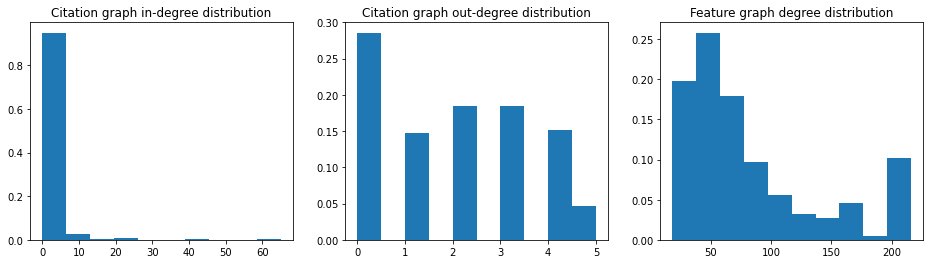

In [57]:
degrees_feature = np.sum(A_feature, axis=1)
degrees_citation_in = np.sum(adj_RL_np.T, axis=1)
degrees_citation_out = np.sum(adj_RL_np, axis=1)

deg_hist_normalization = np.ones(degrees_citation_in.shape[0]) / degrees_citation_in.shape[0]
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].set_title('Citation graph in-degree distribution')
axes[0].hist(degrees_citation_in, weights=deg_hist_normalization);
axes[1].set_title('Citation graph out-degree distribution')
axes[1].hist(degrees_citation_out, weights=deg_hist_normalization);
axes[2].set_title('Feature graph degree distribution')
axes[2].hist(degrees_feature, weights=deg_hist_normalization);

From here onwards, we will conisider only undirected graphs.
Make the adjacency matrix symmetric for the citation graph and compute the degree distribution of the undirected citation graph.

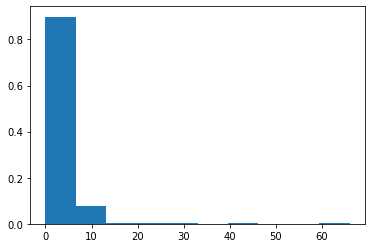

In [63]:
A_citation = np.maximum(adj_RL_np, adj_RL_np.transpose())
degrees_citation = np.sum(A_citation, axis=1)
plt.hist(degrees_citation, weights=deg_hist_normalization);


 Calculate the first and second moments of the degree distribution of each graph.

In [66]:
cit_moment_1 = 1/A_citation.shape[0] * np.sum(A_citation)/2
cit_moment_2 = 1/A_citation.shape[0] * np.sum(A_citation*A_citation)/2

feat_moment_1 = 1/A_feature.shape[0] * np.sum(A_feature)/2
feat_moment_2 = 1/A_feature.shape[0] * np.sum(A_feature*A_feature)/2

print(f"1st moment of citation graph: {cit_moment_1}")
print(f"2nd moment of citation graph: {cit_moment_2}")
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of citation graph: 1.8847926267281105
2nd moment of citation graph: 1.8847926267281105
1st moment of feature graph: 41.22119815668203
2nd moment of feature graph: 41.22119815668203


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**Your answer here:** 


Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

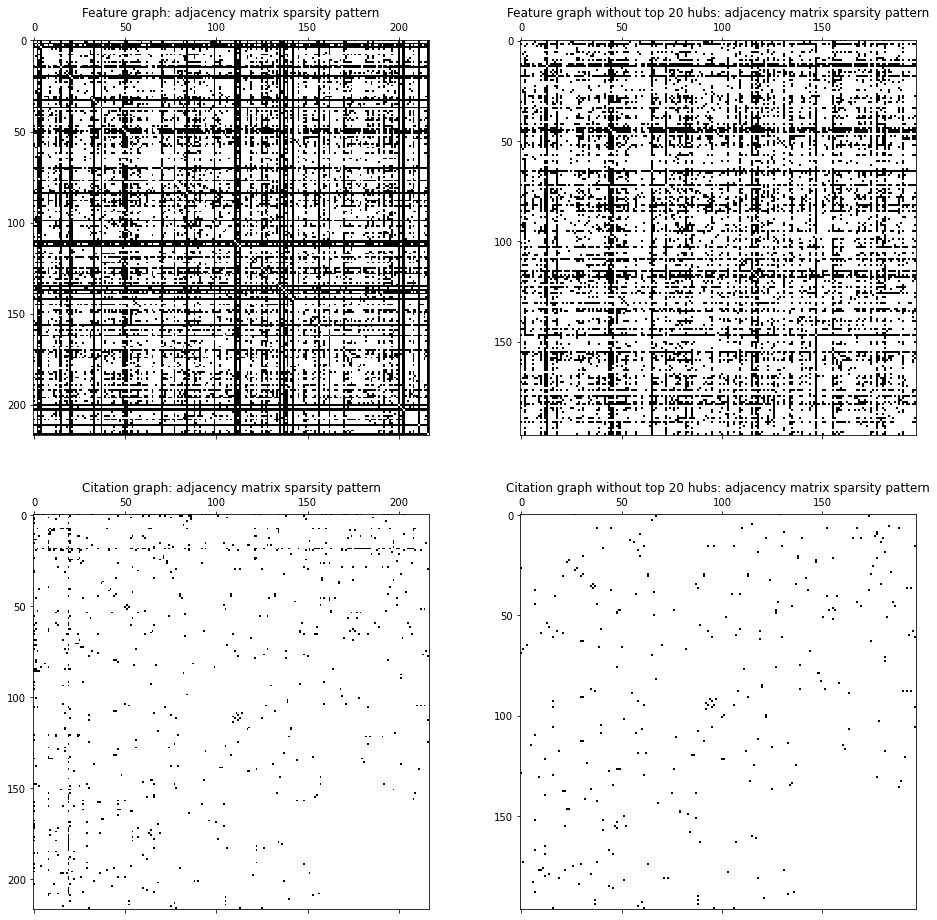

In [82]:
# get degrees of the new unordered one

sorted_deg_feature = (-degrees_feature).argsort()[:20]
del_feature = np.delete(A_feature,sorted_deg_feature,0)
reduced_A_feature = np.delete(del_feature,sorted_deg_feature,1)

sorted_deg_citation = (-degrees_citation).argsort()[:20]
del_citation = np.delete(A_citation,sorted_deg_citation,0)
reduced_A_citation = np.delete(del_citation,sorted_deg_citation,1)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);


Plot the new degree distribution histograms.

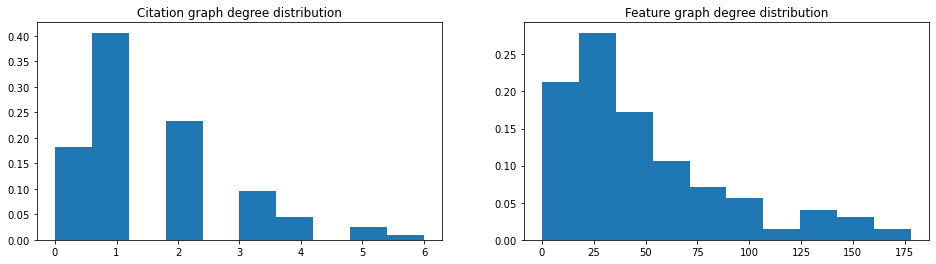

In [83]:
reduced_degrees_feat = np.sum(reduced_A_feature, axis=1)
reduced_degrees_cit = np.sum(reduced_A_citation, axis=1)

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0]) / reduced_degrees_feat.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(reduced_degrees_cit, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(reduced_degrees_feat, weights=deg_hist_normalization);

Compute the first and second moments for the new graphs.

In [84]:

reduced_cit_moment_1 = 1/reduced_A_citation.shape[0] * np.sum(reduced_A_citation)/2
reduced_cit_moment_2 = 1/reduced_A_citation.shape[0] * np.sum(reduced_A_citation*reduced_A_citation)/2

reduced_feat_moment_1 = 1/reduced_A_feature.shape[0] * np.sum(reduced_A_feature)/2
reduced_feat_moment_2 = 1/reduced_A_feature.shape[0] * np.sum(reduced_A_feature*reduced_A_feature)/2

print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 0.766497461928934
Citation graph second moment: 0.766497461928934
Feature graph first moment:  24.578680203045682
Feature graph second moment:  24.578680203045682


Print the number of edges in the reduced graphs.

In [85]:
nb_edges_cit = np.sum(reduced_A_citation)/2
nb_edges_feat = np.sum(reduced_A_feature)/2
print("Citation graph number of edges:", nb_edges_cit)
print("Feature graph number of edges:", nb_edges_feat)

Citation graph number of edges: 151.0
Feature graph number of edges: 4842.0


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

**Your answer here:** 

### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [ ]:
threshold =# Your code here.

A_feature_pruned = # Your code here.
num_edges_feature_pruned = # Your code here.

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Check your results by comparing the sparsity patterns and total number of edges between the graphs.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [ ]:
path_matrix_citation = # Your code here.
path_matrix_feature = # Your code here.

Check the sparsity pattern for both of path matrices.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation);
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature);

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

In [ ]:
path_matrix_pruned = # Your code here.

plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here:** 


Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here:** 

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here:** 

If any of your graphs is connected, calculate the diameter using that process.

In [ ]:
diameter = # Your code here.
print(f"The diameter is: {diameter}")

### Question 4: Shortest path

 Finding the shortest paths between agents

Here, we calculate the shortest path from a source node to a target node. A classic method for finding the shortest path on unweighted networks is Breadth-First Search (BFS) method. Check the BFS steps in the Lecture 'Graph Theory Basis'.

To this end, we first define a function for finding the neighboring nodes of a specified node x. 

In [ ]:
### Get the neighboring set of node x
def find_neighbors(x):
    return [i for i in range(A_feature.shape[0]) if A_feature[x][i]>0]

Calculate the path length from the source node to the target node by filling the missing code in the algorithm: 

In [ ]:
### Find the shortest path from the source node to the target node:
source_node, target_node, path_length = 0, 10, 0
source_set = [source_node]
path = []
stop_finding = 0
iteration_number = A_feature.shape[0]
i = 0
if source_node==target_node:
    stop_finding = 1
    path.append([source_node,target_node,path_length])
while stop_finding == 0 and i < iteration_number:
    source_set_new = []
    for n in source_set:
        neighbors = find_neighbors(n)
        if target_node in neighbors:
             # Code to be filled
            stop_finding = 1
            break
        else:
            for nn in neighbors:
               # Code to be filled
            source_set_new += neighbors
    path_length += 1
    source_set = source_set_new.copy()
    i += 1
if stop_finding == 0:
    path_length = ['Infinity']
    shortest_path = ['None']
else:
    child_node = target_node
    shortest_path = [target_node]
    for i in range(path_length-1,-1,-1):
        parent_node = [x for [x, y, z] in path if y==child_node and z==i]
        shortest_path.append(parent_node[0])
        child_node = parent_node[0] #Select one of the parent nodes as the child node in previous round
    shortest_path.reverse()

print(f"The shortest path length from node {source_node} to node {target_node} is: {path_length}")
print(f"One shortest path is: {shortest_path}")

Get all edges visited by BFS starting from a source node by filling the missing lines in the following code: 

In [ ]:
# All edges visited by BFS method starting from a source node
# All edges visited by BFS method starting from a source node
BFS_edges = []
unexplored_list = list(range(A_feature.shape[0]))
source_node = 0
source_set = [source_node]
unexplored_list.remove(source_node) 
stop_finding = 0
while stop_finding == 0:
    source_set_new = []
    for n in source_set:
        neighbors = find_neighbors(n)
        for nn in neighbors:
            if nn in unexplored_list:
                # Code to be filled
                # Code to be filled
                source_set_new.append(nn)
    if not source_set_new:
        stop_finding = 1      
    else:
        source_set = source_set_new.copy()
print(f"Edges visited by Breadth-First Search method starting from node {source_node}:")
list(BFS_edges)

Question: What is the difference between BFS algorithm and the Dijkstra's algorithm?

Your answer here: Dijkstra's algorithm is an extension of the BFS algorithm from unweighted networks to the weighted networks. 

Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [ ]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

Let us now check our results of BFS method using NetworkX.

In [ ]:
list(nx.bfs_edges(feature_graph, source_node))

In [ ]:
print(nx.shortest_path(feature_graph, source_node, target_node))

## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [ ]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section. 

In [ ]:

G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(nx.number_of_selfloops(G_citation), nx.number_connected_components(G_citation)))

In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [ ]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(nx.number_of_selfloops(G_feature), nx.number_connected_components(G_feature)))

### Question 5: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [ ]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [ ]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
m

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:** 

In [ ]:
p = # Your code here.
G_er = nx.erdos_renyi_graph(n, p)

Check the number of edges in the Erdős–Rényi graph.

In [ ]:
print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**Your answer here:** 

In [ ]:
q = # Your code here.
G_ba = nx.barabasi_albert_graph(n, q)

Check the number of edges in the Barabási–Albert graph.

In [ ]:
print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

### Question 6: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [ ]:
giant_citation = # Your code here.
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

In [ ]:
giant_feature = # Your code here.
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

Check the size of the giant components in the generated Erdős–Rényi graph.

In [ ]:
giant_er = G_er.subgraph(max(nx.connected_components(G_er), key=len))
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**Your answer here:**  

In [ ]:

p_new = # Your code here.
G_er_new = nx.erdos_renyi_graph(n, p_new)

Check the size of the new Erdős–Rényi network and its giant component.

In [ ]:
print('My new Erdos Renyi network that simulates the citation graph has {} edges.'.format(G_er_new.size()))
giant_er_new = G_er_new.subgraph(max(nx.connected_components(G_er_new), key=len)) # Your code here.
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

### Question 7: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees = # Your code here.
axes[0].hist(citation_degrees);
axes[1].set_title('Feature graph')
feature_degrees = # Your code here.
axes[1].hist(feature_degrees);

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**Your answe here:** 

Now, plot the degree distribution historgrams for the simulated networks.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].set_title('Erdos-Rényi network')
er_degrees = # Your code here.
axes[0].hist(er_degrees);
axes[1].set_title('Barabási-Albert network')
ba_degrees = # Your code here.
axes[1].hist(ba_degrees);
axes[2].set_title('new Erdos-Rényi network')
er_new_degrees = # Your code here.
axes[2].hist(er_new_degrees);

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**Your answer here:** Degree distribution of the citation graph matches that of the Barabási-Albert network best.

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [ ]:
G_config = nx.configuration_model(feature_degrees) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here:** 

In [ ]:
nx.number_connected_components(G_config)

### Question 8: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [ ]:
nx.average_clustering(G_citation)

In [ ]:
nx.average_clustering(G_feature)

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**Your answer here:** 

Now, let us check the average clustering coefficient for the simulated networks.

In [ ]:
nx.average_clustering(G_er)

In [ ]:
nx.average_clustering(G_ba)

In [ ]:
nx.average_clustering(nx.Graph(G_config))

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:**

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:** Our graphs display more regular patterns than a BA network considering the clustering coefficient, but still seem to have a power-law degree distribution considering the degree distributions. We can try clustered power-law graph, considering the sparsity pattern in the previous section.

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

In [ ]:
# Your code here.

Comment on the similarities of your match.

**Your answer here:** 